In [28]:
import numpy as np
import pandas as pd
import scanpy as sc

import decoupler as dc

import matplotlib.pyplot as plt

def plot_distribution(dataset_name, metric_name, results):
    msk = (results['dataset'] == dataset_name) & (results['metric'] == metric_name)
    random = results[msk]['random']
    gt = results[msk]['gt'].values[0]
    pval = results[msk]['p-value'].values[0]
    # zscore = results[msk]['z-score'].values[0]
    
    # Creating the histogram
    plt.hist(random, bins=30, alpha=0.7, color='blue')
    # Adding a vertical line for the ground truth performance
    plt.axvline(gt, color='red', linestyle='dashed', linewidth=2)

    # Adding labels and title
    plt.xlabel(metric_name)
    plt.ylabel('Frequency')
    plt.title(dataset_name)

    # Adding p-value and z-score as text labels
    plt.text(0.30, 0.95, f'p-value: {pval:.4f}', 
            horizontalalignment='right', verticalalignment='top', 
            transform=plt.gca().transAxes, fontsize=11, color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # Show the plot
    plt.show()

In [24]:
from utils import *

In [3]:
gt = get_ground_truth()

In [4]:
datasets = {}

datasets['Kuppe et al., 2022'] = process_kuppe()
datasets['Reichart et al., 2022'] = process_reichart()
datasets['Simonson et al., 2023'] = process_simonson()
datasets['Koenig et al., 2022'] = process_koenig()

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [5]:
datasets['Chaffin et al., 2022'] = process_chaffin()

In [6]:
datasets['Armute et al., 2023'] = process_armute()

In [7]:
results = pd.DataFrame(columns=['dataset', 'metric', 'gt', 'p-value', 'z-score']).set_index('dataset')
for dataset_name, (pdata, y_true) in datasets.items():
    kmeans = KMeans(n_clusters=2, random_state=0).fit(pdata[:, gt].X)
    gt_ari = adjusted_rand_score(y_true, kmeans.labels_)
    gt_sil = silhouette_score(pdata[:, gt].X, y_true)
    gt_nmi = normalized_mutual_info_score(y_true, kmeans.labels_)


    rng = np.random.default_rng(0)
    subsets = [rng.choice(pdata.var.index, size=len(gt), replace=False) for _ in range(1000)]

    ari = []
    sil = []
    nmi = []
    # Printing subsets to verify
    for i, subset in enumerate(subsets):
        cdata = pdata[:,subset]
        kmeans = KMeans(n_clusters=2, random_state=0).fit(cdata.X)
        ari.append(adjusted_rand_score(y_true, kmeans.labels_))
        # nmi.append(normalized_mutual_info_score(y_true, kmeans.labels_))
        sil.append(silhouette_score(cdata.X, y_true))
        
    # Calculate p-values and z-scores and populate the DataFrame
    metrics = {'ARI': (gt_ari, ari),
               'Silhouette': (gt_sil, sil),
            #    'NMI': (gt_nmi, nmi)
               }
    for metric_name, (gt_metric, metric_scores) in metrics.items():
        pvalue, zscore = calculate_p_value(gt_metric, metric_scores)
        results = results.append({'dataset': dataset_name, 
                                  'metric': metric_name, 
                                  'gt': gt_metric,
                                  'random': metric_scores,
                                  'p-value': pvalue,
                                  'z-score': zscore},
                                 ignore_index=True)


/tmp/ipykernel_3155727/2802190459.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_3155727/2802190459.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_3155727/2802190459.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_3155727/2802190459.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_3155727/2802190459.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_3155727/2802190459.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

In [8]:
results.groupby('metric').mean()

/tmp/ipykernel_3155727/1291209334.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,gt,p-value,z-score
metric,,,
ARI,0.421460,0.126718,1.647445
Silhouette,0.113922,0.199742,1.387911


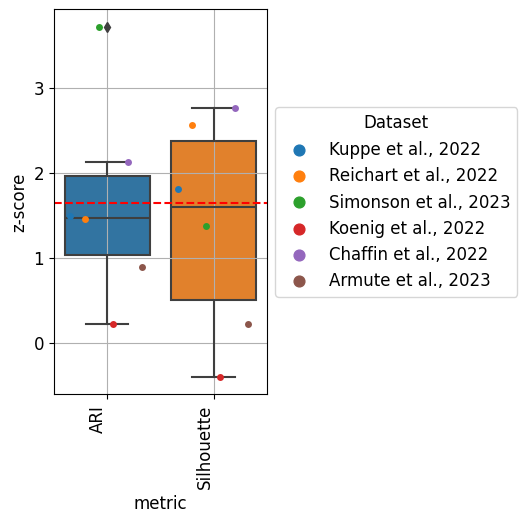

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase font size
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(2.75, 5))
ax = sns.boxplot(x='metric', y='z-score', data=results)
sns.stripplot(x='metric', y='z-score', data=results, hue='dataset', dodge=True, jitter=True, ax=ax)
plt.axhline(y=1.645, color='red', linestyle='dashed')
plt.xticks(rotation=90, ha='right')
plt.legend(title='Dataset', bbox_to_anchor=(1.00, 0.5), loc='center left')
plt.grid(True)

plt.show()

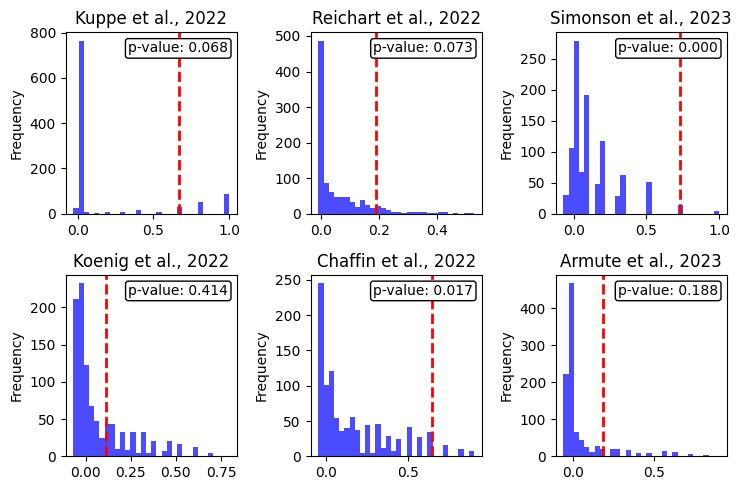

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Increase font size
plt.rcParams.update({'font.size': 10})

def plot_distribution(dataset_name, metric_name, results, ax):
    msk = (results['dataset'] == dataset_name) & (results['metric'] == metric_name)
    random = results[msk]['random']
    gt = results[msk]['gt'].values[0]
    pval = results[msk]['p-value'].values[0]
    zscore = results[msk]['z-score'].values[0]
    
    # Creating the histogram
    ax.hist(random, bins=30, alpha=0.7, color='blue')
    # Adding a vertical line for the ground truth performance
    ax.axvline(gt, color='red', linestyle='dashed', linewidth=2)

    # Adding labels and title
    ax.set_ylabel('Frequency')
    ax.set_title(dataset_name)

    # Adding p-value and z-score as text labels
    ax.text(0.95, 0.95, f'p-value: {pval:.3f}', 
             horizontalalignment='right', verticalalignment='top', 
             transform=ax.transAxes, fontsize=10, color='black',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

# Get the unique datasets
datasets = results['dataset'].unique()

# Create a 3x2 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7.5, 5))

# Flatten the axes array
axs = axs.flatten()

# Create a plot for each dataset
for i, dataset in enumerate(datasets):
    plot_distribution(dataset_name=dataset, metric_name='ARI', results=results, ax=axs[i])

# Remove unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()